<a href="https://colab.research.google.com/github/DexterfreaK/XGboostUrban/blob/master/XGBoost_using_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
%pip install gdal

In [32]:
from osgeo import gdal
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [33]:
# All features in X imported and read as Array

popden = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/popden.tif")
popden = popden.ReadAsArray()
popden = np.where(popden < 0 , np.nan, popden)

Slope = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/slope.tif")
Slope = Slope.ReadAsArray()
Slope = Slope / np.max(Slope)
Slope = np.where(Slope < 0, np.nan, Slope)

Friction = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/friction.tif")
Friction = Friction.ReadAsArray()
Friction = np.where(Friction < 0 , np.nan, Friction)

Elevation = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/elevation.tif")
Elevation = Elevation.ReadAsArray()
Elevation = np.where(Elevation < 0 , np.nan, Elevation)

gdp2005 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/gdp2005.tif")
gdp2005 = gdp2005.ReadAsArray()
gdp2005 = np.where(gdp2005 < 0 , np.nan, gdp2005)


floods = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/floods.tif")
floods = floods.ReadAsArray()
floods = np.where(floods < 0 , np.nan, floods)

accessibility = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/accessibility.tif")
accessibility = accessibility.ReadAsArray()
accessibility = np.where(accessibility < 0 , np.nan, accessibility)

builtup_05_06 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/05_06_builtup.tif")
builtup_05_06 = builtup_05_06.ReadAsArray()
builtup_05_06 = np.where(builtup_05_06 < 0 , np.nan, builtup_05_06)

# Required Shape checking for All features
assert Slope.shape == popden.shape == Friction.shape == Elevation.shape == gdp2005.shape == floods.shape == accessibility.shape == builtup_05_06.shape

(l,w) = Slope.shape

# Reshaping the image to be a 1d Array
Slope = np.reshape(Slope, (l*w,1))
popden = np.reshape(popden, (l*w,1))
Friction = np.reshape(Friction, (l*w,1))
Elevation = np.reshape(Elevation, (l*w,1))
floods = np.reshape(floods, (l*w,1))
accessibility = np.reshape(accessibility, (l*w,1))
builtup_05_06 = np.reshape(builtup_05_06, (l*w,1))
gdp2005 = np.reshape(gdp2005, (l*w,1))


In [34]:
# Slope_data = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/slope.tif")
# Slope = Slope_data.ReadAsArray()
# # Slope = Slope / np.max(Slope)
# # Slope = np.where(Slope < 0, np.nan, Slope)


# write_geotiff('Slope.tiff',Slope,Slope_data)

In [35]:
#Opening and Reading Y data
Subtracted_builtup_05_06_gdal_data = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/11_12_builtup.tif")
Subtracted_builtup_05_06 = Subtracted_builtup_05_06_gdal_data.ReadAsArray()
Subtracted_builtup_05_06 = np.where(Subtracted_builtup_05_06 < 0 , np.nan, Subtracted_builtup_05_06)

assert Subtracted_builtup_05_06.shape == (l,w)

#Opening and Reshaping the data
Subtracted_builtup_05_06 = np.reshape(Subtracted_builtup_05_06, (l*w,1))

In [36]:
# Converting the array data to dataframe for both X and Y
df = pd.DataFrame({
    'Slope': Slope.flatten(),
    'Elevation': Elevation.flatten(),
    'PopDen': popden.flatten(),
    'Friction': Friction.flatten(),
    'Floods': floods.flatten(),
    'Accessibility': accessibility.flatten(),
    'Gdp2005': gdp2005.flatten(),
    'builtup_05_06': builtup_05_06.flatten(),
    'Y_Subtracted_builtup_11_05': Subtracted_builtup_05_06.flatten(),
})


In [37]:
df.describe()

,Slope,Elevation,PopDen,Friction,Floods,Accessibility,Gdp2005,builtup_05_06,Y_Subtracted_builtup_11_05
count,3.286406e+06,3.304610e+06,3.256383e+06,3.151029e+06,1.807469e+06,3.167730e+06,2.002123e+06,3.331200e+06,3.331200e+06
mean,8.173062e-04,8.932072e-01,7.454635e-02,9.203656e-01,8.886334e-01,8.687662e-01,1.777354e-01,7.026747e-02,7.125600e-02
std,2.857689e-02,1.544069e-01,1.540960e-01,1.547747e-01,2.471501e-01,1.686289e-01,2.715401e-01,2.555973e-01,2.572520e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.926445e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.533235e-39,8.791045e-01,0.000000e+00,9.616657e-01,1.000000e+00,7.885317e-01,1.772051e-02,0.000000e+00,0.000000e+00
50%,2.894197e-39,9.268657e-01,0.000000e+00,9.871570e-01,1.000000e+00,9.208127e-01,4.634973e-02,0.000000e+00,0.000000e+00
75%,2.941177e-39,1.000000e+00,8.384361e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.996024e-01,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [38]:
# dropping Y from X
X = df.drop('Y_Subtracted_builtup_11_05', axis=1)
Y = df['Y_Subtracted_builtup_11_05']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .80)

In [40]:
params = {
            'max_depth': 6,
            'learning_rate': .3,
        }

xgb_model=XGBClassifier(**params)
model=xgb_model.fit(X_train,y_train)

In [41]:
# Predicting the Test set results
y_pred = model.predict(X_test)

Import some metrics and checking models' score

In [42]:
#Import some metrics.
from sklearn.metrics import precision_score, recall_score, accuracy_score
print("Type = {}".format(type(model)))
print("Precision = {}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall = {}".format(recall_score(y_test, y_pred, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))


Type = <class 'xgboost.sklearn.XGBClassifier'>
Precision = 0.9682693472519711
Recall = 0.9529418009406387
Accuracy = 0.989614853506244


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

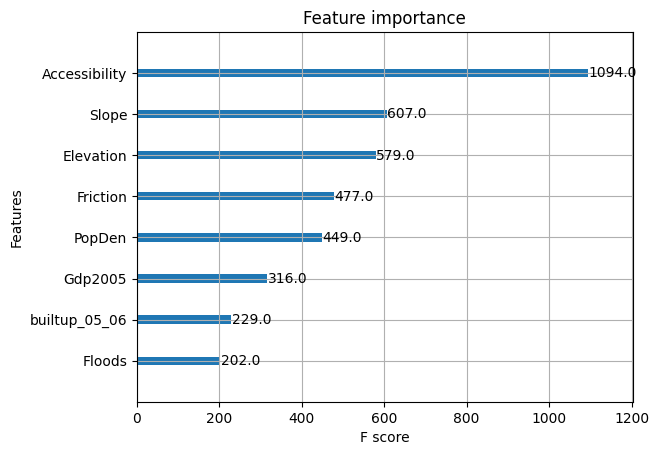

In [43]:
from xgboost import plot_importance
plot_importance(xgb_model)

Select parameters with `GridSearch`

**Prediction of the Urbanised Map**

In [44]:
y_pred = model.predict(X)
y_pred = np.reshape(y_pred,(l,w)).astype(np.float32)

Converting predicted array to tiff image

In [45]:
def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)

In [46]:
write_geotiff('Predicted_subtracted_0.3_difference_withoutSlope.tiff',y_pred,Subtracted_builtup_05_06_gdal_data)

In [49]:
from sklearn.model_selection import GridSearchCV

clf = XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "n_estimators"     : [10, 20, 30]
     }

grid = GridSearchCV(clf, parameters, n_jobs=10, cv=3, verbose=3)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
# def get_upper_left_coordinate(tiff_path):
#     dataset = gdal.Open(tiff_path)
#     geotransform = dataset.GetGeoTransform()
#     x = geotransform[0]
#     y = geotransform[3]

#     return (x,y)

# get_upper_left_coordinate('/content/drive/MyDrive/AdjustedData_23_metre_Resolution/11_12_builtup.tif')

In [ ]:
# import os
# from osgeo import gdal
# from osgeo import osr
# import numpy

# # config
# GDAL_DATA_TYPE = gdal.GDT_Float32
# GEOTIFF_DRIVER_NAME = r'GTiff'
# NO_DATA = 0
# SPATIAL_REFERENCE_SYSTEM_WKID = 4326

# def create_raster(output_path,
#                   columns,
#                   rows,
#                   nband = 1,
#                   gdal_data_type = GDAL_DATA_TYPE,
#                   driver = GEOTIFF_DRIVER_NAME):
#     ''' returns gdal data source raster object

#     '''
#     # create driver
#     driver = gdal.GetDriverByName(driver)

#     output_raster = driver.Create(output_path,
#                                   int(columns),
#                                   int(rows),
#                                   nband,
#                                   eType = gdal_data_type)
#     return output_raster

# def numpy_array_to_raster(output_path,numpy_array,upper_left_tuple,cell_resolution,nband = 1,no_data = NO_DATA,gdal_data_type = GDAL_DATA_TYPE,spatial_reference_system_wkid = SPATIAL_REFERENCE_SYSTEM_WKID,driver = GEOTIFF_DRIVER_NAME):

#     (rows, columns) = numpy_array.shape

#     output_raster = create_raster(output_path,int(columns),int(rows),nband,gdal_data_type)

#     geotransform = (upper_left_tuple[0],cell_resolution,-1* cell_resolution,upper_left_tuple[1],-1 *(cell_resolution),0)

#     spatial_reference = osr.SpatialReference()
#     spatial_reference.ImportFromEPSG(spatial_reference_system_wkid)
#     output_raster.SetProjection(spatial_reference.ExportToWkt())
#     output_raster.SetGeoTransform(geotransform)
#     output_band = output_raster.GetRasterBand(1)
#     output_band.WriteArray(numpy_array)
#     output_band.FlushCache()
#     output_band.ComputeStatistics(False)

#     if os.path.exists(output_path) == False:
#         raise Exception('Failed to create raster: %s' % output_path)

#     return  output_raster



In [ ]:
# upper_left_tuple = get_upper_left_coordinate("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/05_06_builtup.tif")
# pixel_res = 0.0002262608069164277378
# numpy_array_to_raster('Final.tiff',builtup_05_06,upper_left_tuple,pixel_res)

